In [1]:
cd ../../

/workspaces/research/motor-decoding


In [2]:
import json
import sys
from collections import Counter
from itertools import cycle
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd

from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne_bids import BIDSPath
from mne_bids.read import read_raw_bids
from mne_bids.tsv_handler import _from_tsv
from rerf.rerfClassifier import rerfClassifier
from scipy.io import loadmat
from scipy.spatial.distance import euclidean
from scipy import stats
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, label_binarize
from tqdm import tqdm

from mtsmorf.io.read import read_dataset, read_label, read_trial, get_trial_info, _get_bad_chs
from mtsmorf.io.utils import NumpyEncoder
from mtsmorf.io.experiments import cv_fit, run_classifier_comparison

from mtsmorf.move_exp.plotting import (
    plot_signals,
    plot_roc_multiclass_cv,
    plot_feature_importances,
    plot_cv_indices,
    plot_accuracies,
    plot_roc_aucs,
)

# plt.style.use(['science', 'ieee', 'no-latex'])

%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set_palette("Set2")

In [3]:
def plot_epochs(epochs, labels, picks=None):

    drop_inds = {k : np.where(labels != k)[0] for k in np.unique(labels)}
    label_names = {0: "Down", 1: "Right", 2: "Up", 3: "Left"}

    epochs_by_direction = {}
    for k, v in drop_inds.items():
        tmp = epochs.copy()
        tmp.drop(v)
        epochs_by_direction[k] = tmp

    for k, ep in epochs_by_direction.items():
        fig = ep.plot(
            picks=picks,
            scalings=dict(seeg=1e2), 
            n_epochs=5,
            show=False,
            title=label_names[k],
        )
        fig.suptitle(label_names[k])
        fig.set_size_inches(18, 4, forward=True)
        plt.show()

    for i, (k, ep) in enumerate(epochs_by_direction.items()):
        ep.plot_image(
            picks=picks,
            scalings=dict(seeg=1e-6),
            title=f"{label_names[k]}: {picks}"
        )

In [4]:
subjects = [
    "efri02",
    "efri06",
    "efri07",
    "efri09",  # Too few samples
    "efri10",  # Unequal data size vs label size
    "efri13",
    "efri14",
    "efri15",
    "efri18",
    "efri20",
    "efri26",
]

# bids_root = Path("/Volumes/mac/research/data/efri/")
bids_root = Path("/workspaces/research/mnt/data/efri")

# subject identifiers
session = "efri"
task = "move"
acquisition = "seeg"
run = "01"
kind = "ieeg"

channels = []
for subject in subjects:
    bids_path = BIDSPath(subject=subject, session=session, task=task,
                        acquisition=acquisition, run=run, suffix=kind, extension=".tsv", root=bids_root)
    bids_path.update(suffix="channels")
    bads = _get_bad_chs(bids_path)
    
    tmp = _from_tsv(bids_path)
    tmp = [
        (name, anat, subject) 
        for (name, anat) in zip(tmp["name"], tmp["anat"]) 
        if name not in bads
    ]

    channels.extend(tmp)

channels = pd.DataFrame(channels, columns=["name", "anat", "subject"])
channels.head()
sorted_channels = channels.sort_values(["anat", "subject"])


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


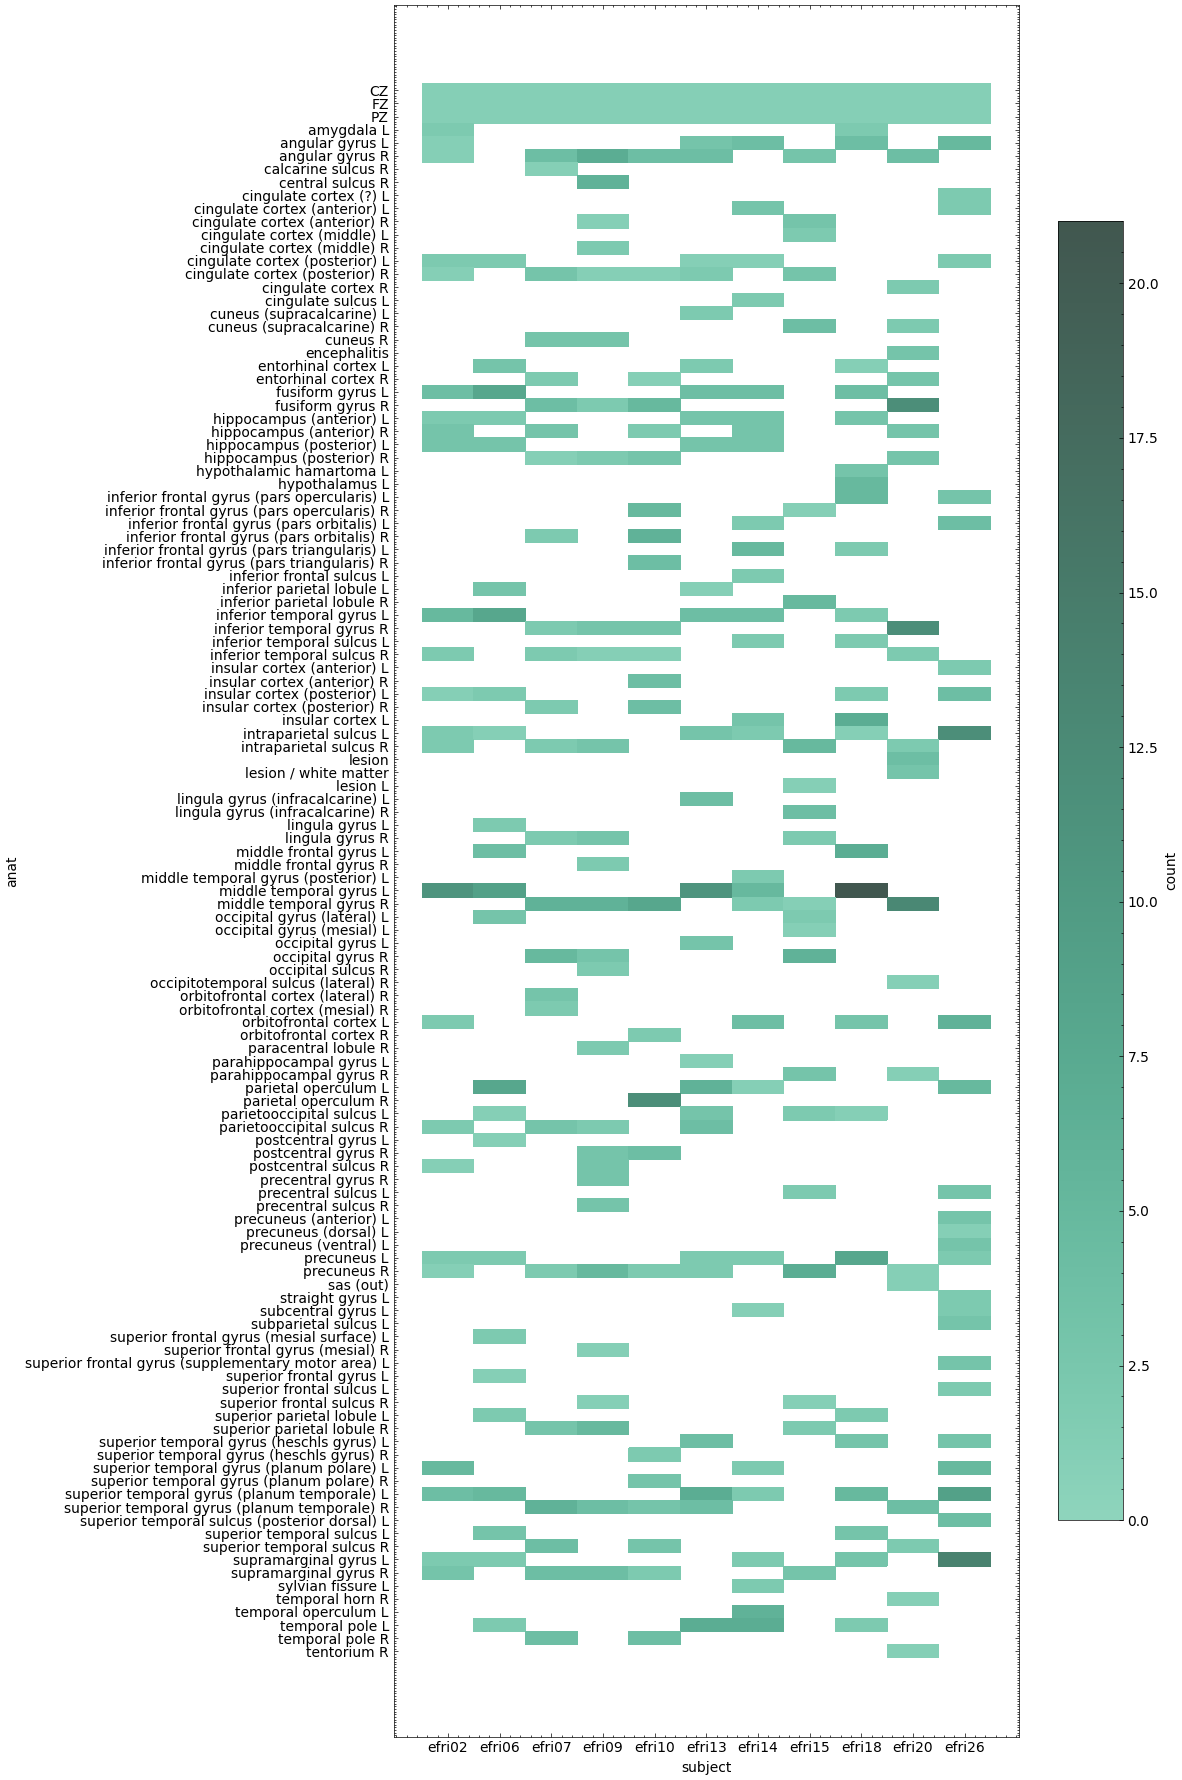

In [5]:
fig, ax = plt.subplots(dpi=100, figsize=(12, 18))

sns.histplot(
    data=sorted_channels, x="subject", y="anat", 
    cbar=True, cbar_kws=dict(shrink=.75, label="count"), ax=ax,
)
fig.tight_layout();

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


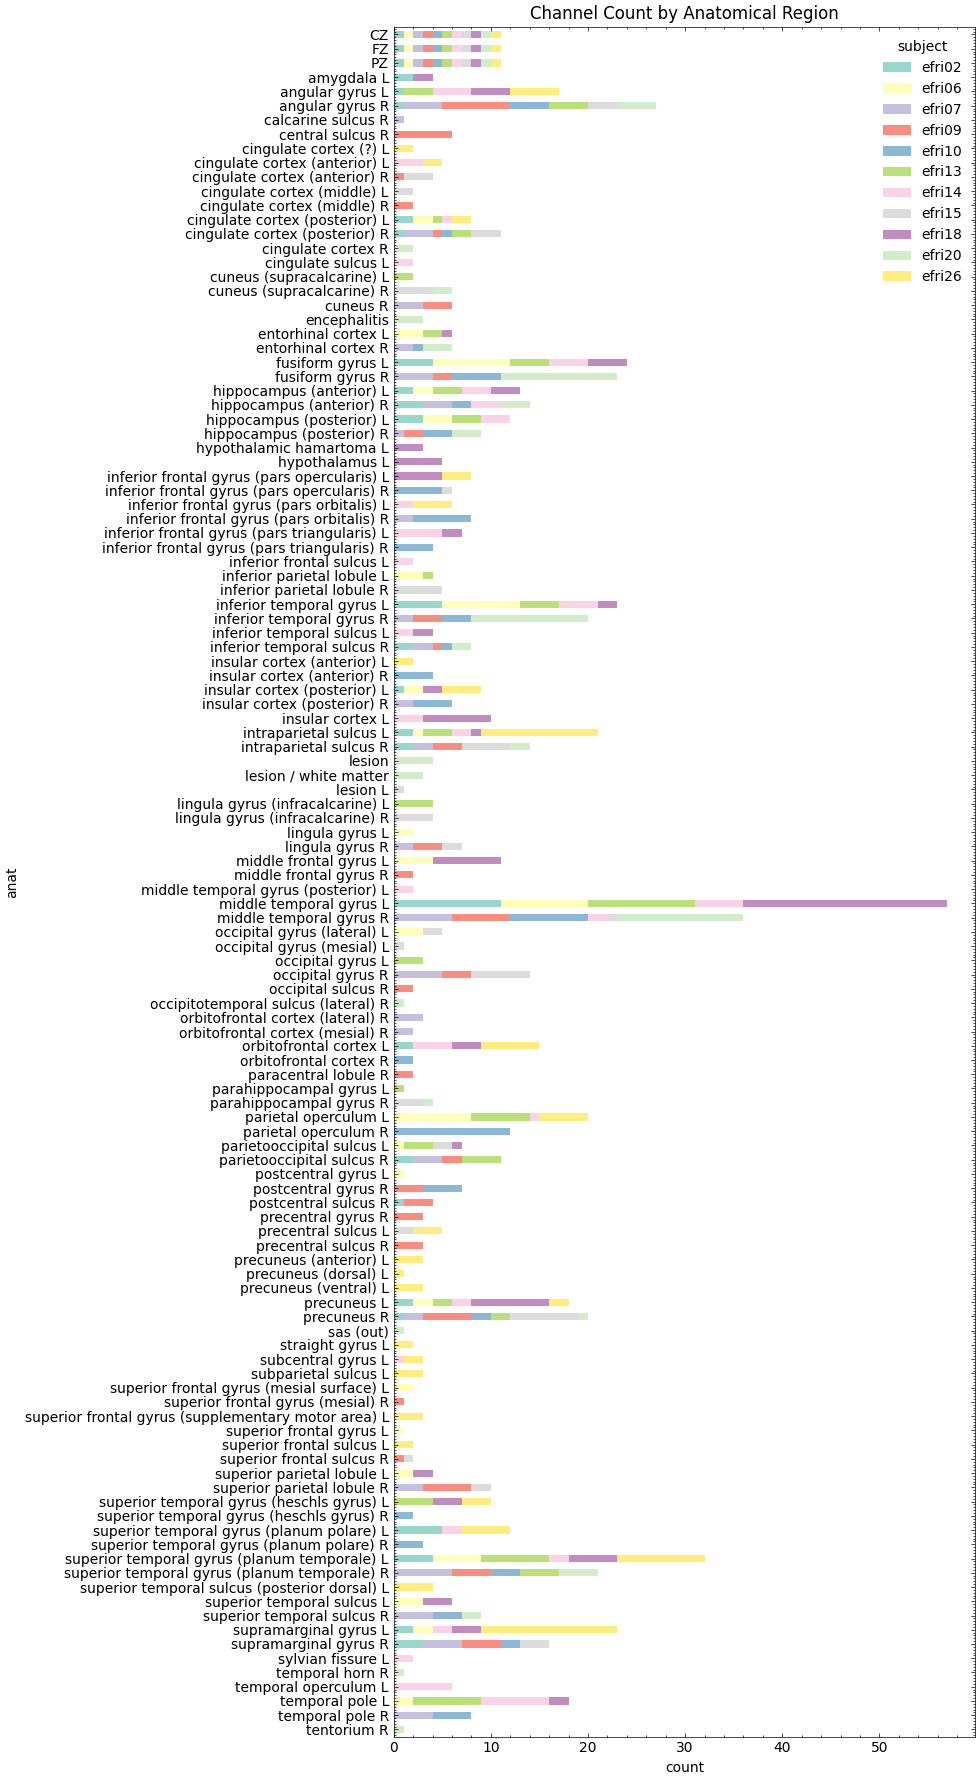

In [6]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 18))

df_plot = sorted_channels.groupby(['anat', 'subject']).size().reset_index().pivot(columns='subject', index='anat', values=0)
df_plot = df_plot.sort_values('anat', ascending=False)  # To get y-axis into the same order as above
df_plot.fillna(0)
df_plot.plot(kind="barh", stacked=True, colormap="Set3", alpha=0.9, ax=ax)
ax.set(xlabel="count", ylabel="anat", title="Channel Count by Anatomical Region")
fig.tight_layout();

## EFRI14

In [7]:
bids_root = Path("/Volumes/mac/research/data/efri/")
# bids_root = Path("/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/data/efri/")

tmin, tmax = (-0.75, 1.25)

bids_root = Path("/workspaces/research/mnt/data/efri")
derivatives_path = (
    bids_root / "derivatives" / "preprocessed" / f"tmin={tmin}-tmax={tmax}" / "band-pass=1-1000Hz-downsample=500"
)

# subject identifiers
subject = "efri14"
session = "efri"
task = "move"
acquisition = "seeg"
run = "01"
kind = "ieeg"

bids_path = BIDSPath(subject=subject, session=session, task=task,
                     acquisition=acquisition, run=run, suffix=kind, extension=".vhdr", root=bids_root)

In [8]:
# fetch labels
labels, trial_ids = read_label(bids_path, trial_id=None, label_keyword="target_direction")

# we don't want perturbed trials
behav_tsv, events_tsv = get_trial_info(bids_path)
success_trial_flag = np.array(list(map(int, behav_tsv["successful_trial_flag"])))
success_inds = np.where(success_trial_flag == 1)[0]
force_mag = np.array(behav_tsv['force_magnitude'], np.float64)[success_inds]

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where((np.isnan(labels) | (force_mag > 0)))[0]
labels = np.delete(labels, unsuccessful_trial_inds)

# get preprocessed epochs data
fname = os.path.splitext(bids_path.basename)[0] + "-epo.fif"
fpath = derivatives_path / subject / fname

epochs = mne.read_epochs(fpath, preload=True)
epochs = epochs.drop(unsuccessful_trial_inds)

Out of 163 trials, there were 154 successful trials in /workspaces/research/mnt/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Out of 163 trials, there were 154 successful trials in /workspaces/research/mnt/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Reading /workspaces/research/mnt/data/efri/derivatives/preprocessed/tmin=-0.75-tmax=1.25/band-pass=1-1000Hz-downsample=500/efri14/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -750.00 ...    1248.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
154 matching events found
No baseline correction applied
0 projection items activated
Dropped 26 epochs: 14, 16, 17, 20, 21, 27, 28, 29, 31, 33, 54, 63, 79, 84, 87, 91, 110, 118, 123, 125, 132, 135, 138, 140, 141, 148


Dropped 96 epochs: 0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 21, 22, 24, 25, 26, 27, 28, 32, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 57, 58, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 92, 94, 97, 98, 99, 100, 101, 102, 103, 105, 106, 108, 109, 110, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 126, 127
Dropped 98 epochs: 0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 68, 70, 71, 73, 74, 76, 77, 78, 79, 81, 83, 84, 86, 90, 91, 92, 93, 95, 96, 97, 98, 102, 103, 104, 105, 106, 107, 108, 111, 113, 114, 115, 116, 117, 118, 120, 121, 123, 124, 125, 126, 127
Dropped 93 epochs: 1, 2, 3, 4, 5, 7, 9, 10, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 37, 41, 42, 44, 45, 46, 49, 52, 54, 56, 5

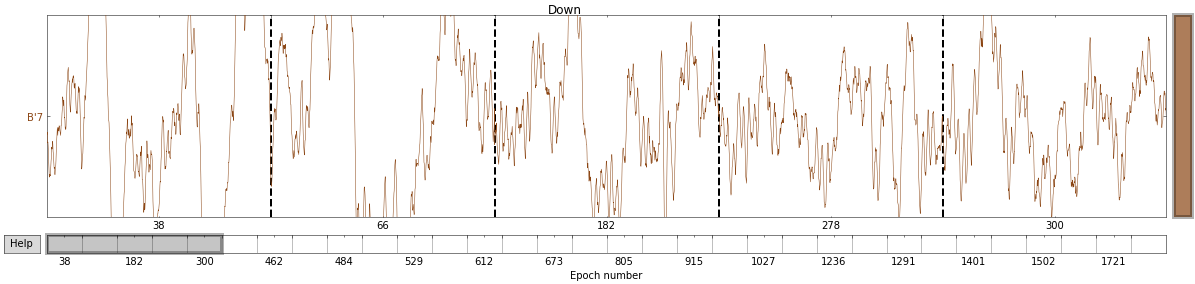

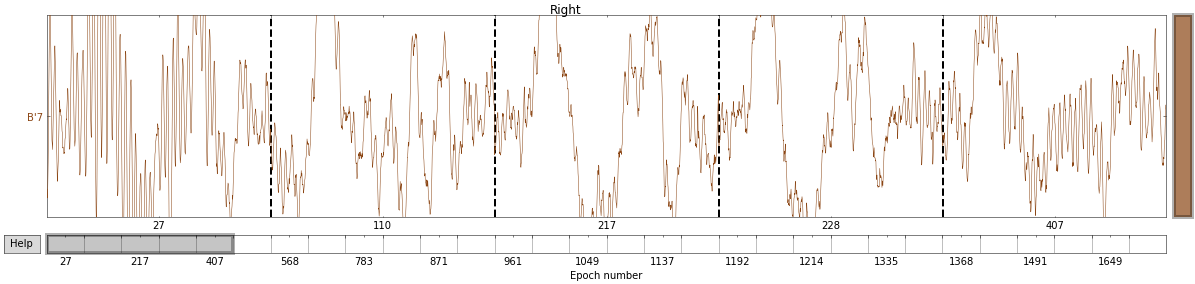

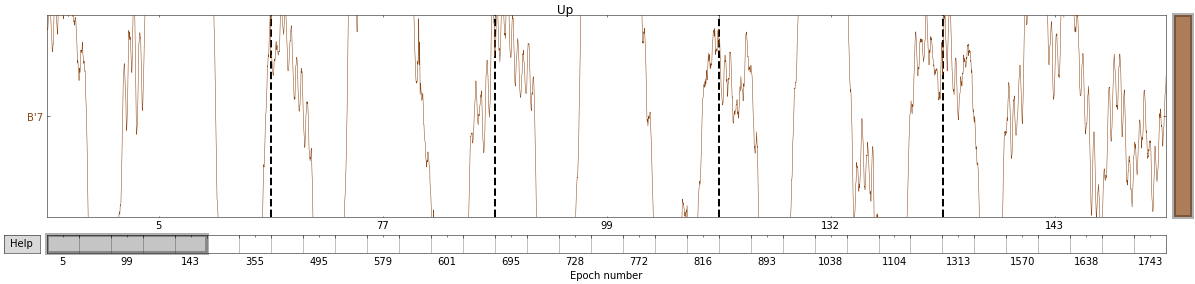

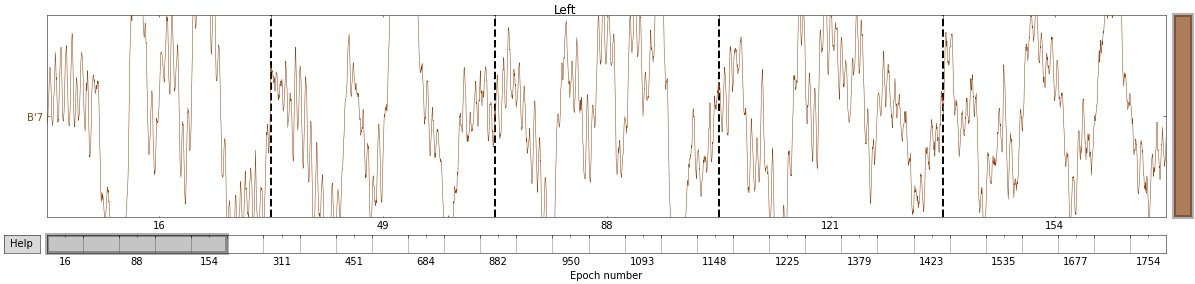

Not setting metadata
Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


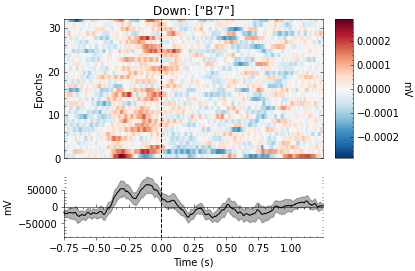

Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


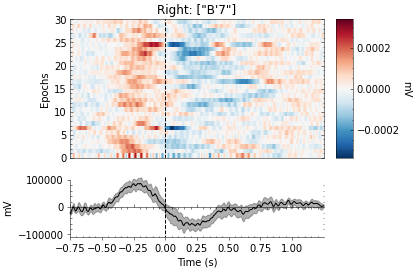

Not setting metadata
Not setting metadata
35 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


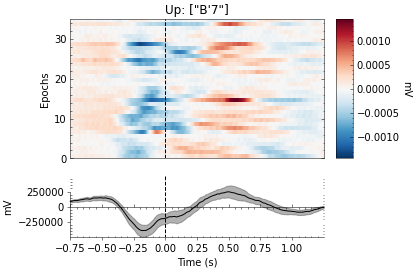

Not setting metadata
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


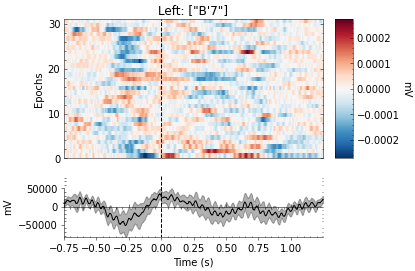

In [9]:
picks = ["B'7"]
plot_epochs(epochs, labels, picks=picks)

In [10]:
bids_path = BIDSPath(subject=subject, session=session, task=task,
                     acquisition=acquisition, run=run, suffix=kind, extension=".tsv", root=bids_root)
bids_path.update(suffix="channels")
bads = _get_bad_chs(bids_path)

tmp = _from_tsv(bids_path)
tmp = [
    (name, anat) 
    for (name, anat) in zip(tmp["name"], tmp["anat"]) 
    if name not in bads
]

channels = pd.DataFrame(tmp, columns=["name", "anat"])
sorted_channels = channels.sort_values(["anat"])
sorted_channels.head()

name             anat
82  REF2               CZ
81  REF1               FZ
83     E               PZ
71  Y'10  angular gyrus L
72   Y'9  angular gyrus L

In [11]:
sorted_channels[sorted_channels["anat"].str.contains("insular cortex|central sulcus|middle temporal gyrus")]

name                                 anat
70  X'1                     insular cortex L
57  T'1                     insular cortex L
52  R'1                     insular cortex L
15  F'9  middle temporal gyrus (posterior) L
16  F'8  middle temporal gyrus (posterior) L
0   B'8              middle temporal gyrus L
1   B'7              middle temporal gyrus L
2   B'6              middle temporal gyrus L
6   C'8              middle temporal gyrus L
7   C'7              middle temporal gyrus L
77   B6              middle temporal gyrus R
76   B7              middle temporal gyrus R

In [12]:
anat = sorted_channels["anat"].str.contains("insular cortex|central sulcus|middle temporal gyrus")
picks = list(sorted_channels[anat]["name"])
epochs_anat = epochs.pick_channels(picks)

### Shuffled vs Unshuffled (Time Domain)

100%|██████████| 5/5 [00:58<00:00, 11.75s/it]


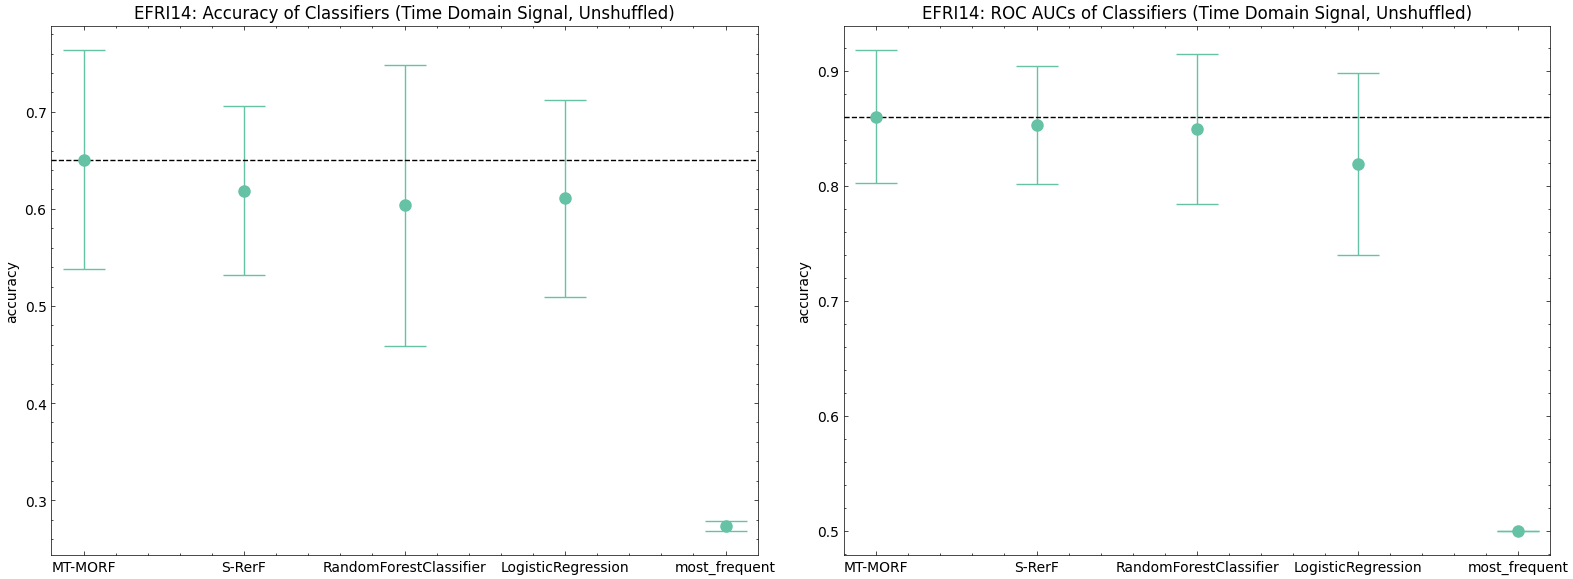

In [13]:
rng = 1
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

## Fit model
clf_scores = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=False, shuffle_channels=False, random_state=rng)

## Plot results
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(16, 6))
axs = axs.flatten()
plot_accuracies(clf_scores, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (Time Domain Signal, Unshuffled)")

plot_roc_aucs(clf_scores, ax=axs[1])
axs[1].set(ylabel="accuracy", title=f"{subject.upper()}: ROC AUCs of Classifiers (Time Domain Signal, Unshuffled)")

fig.tight_layout();

100%|██████████| 5/5 [00:56<00:00, 11.29s/it]


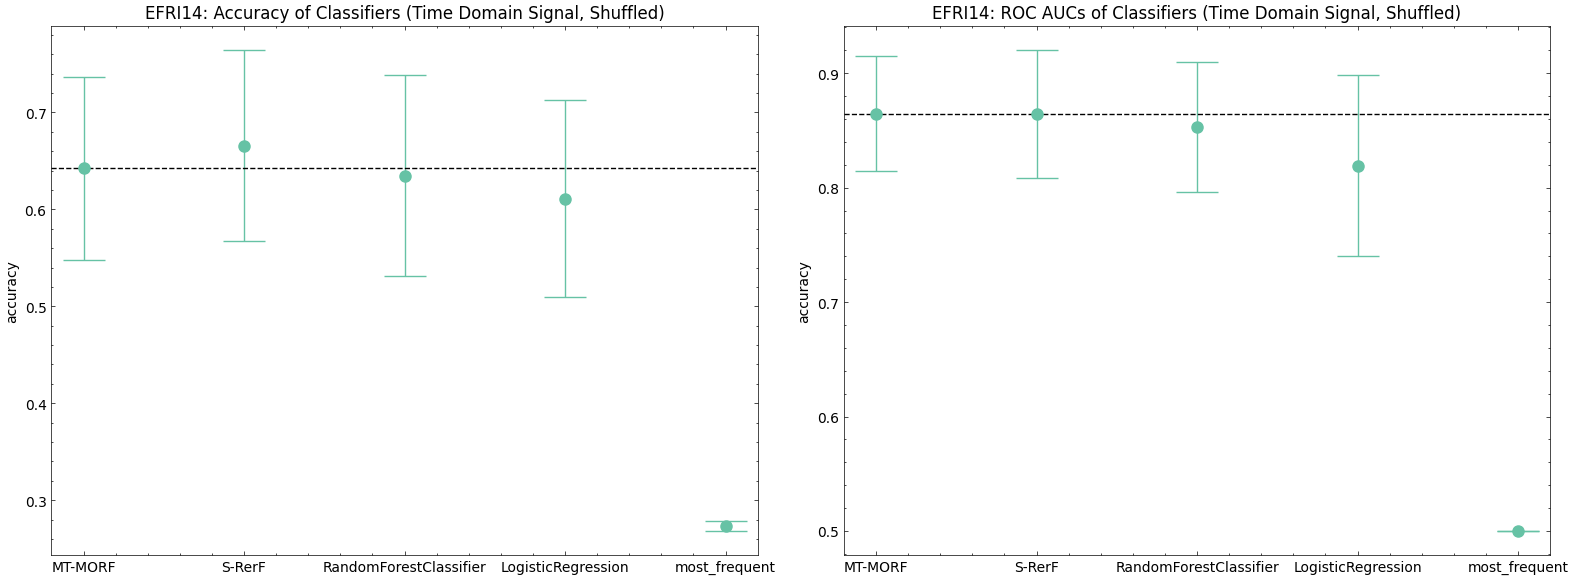

In [14]:
## Fit model
clf_scores = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=False, shuffle_channels=True, random_state=rng)

## Plot results
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(16, 6))
axs = axs.flatten()
plot_accuracies(clf_scores, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (Time Domain Signal, Shuffled)")

plot_roc_aucs(clf_scores, ax=axs[1])
axs[1].set(ylabel="accuracy", title=f"{subject.upper()}: ROC AUCs of Classifiers (Time Domain Signal, Shuffled)")

fig.tight_layout();

### Shuffled vs Unshuffled (Freq Domain, Averaged)

Not setting metadata
100%|██████████| 5/5 [00:33<00:00,  6.72s/it]


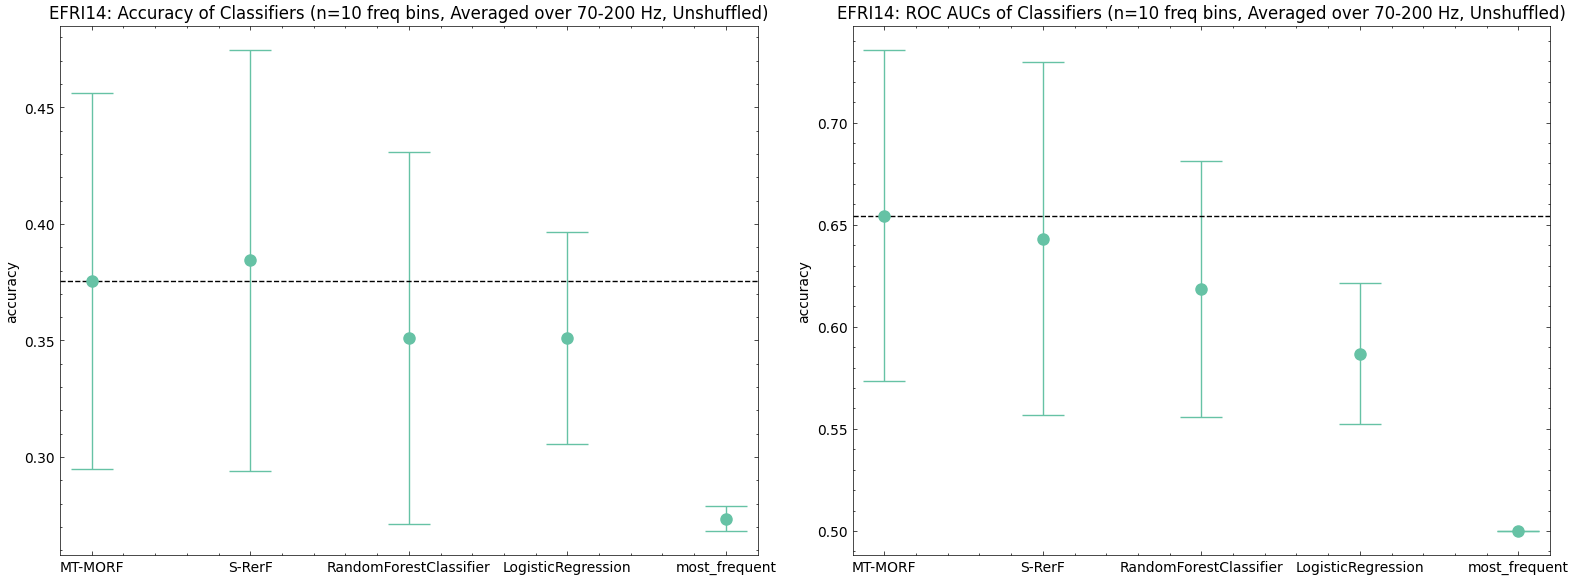

In [15]:
nfreqs = 10
lfreq, hfreq = (70, 200)

## Fit models
clf_scores = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=True, shuffle_channels=False, avg_freq=True, nfreqs=nfreqs, lfreq=lfreq, hfreq=hfreq, random_state=rng)

## Plot results
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(16, 6))
axs = axs.flatten()
plot_accuracies(clf_scores, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (n={nfreqs} freq bins, Averaged over {lfreq}-{hfreq} Hz, Unshuffled)")

plot_roc_aucs(clf_scores, ax=axs[1])
axs[1].set(ylabel="accuracy", title=f"{subject.upper()}: ROC AUCs of Classifiers (n={nfreqs} freq bins, Averaged over {lfreq}-{hfreq} Hz, Unshuffled)")

fig.tight_layout();

Not setting metadata
100%|██████████| 5/5 [00:36<00:00,  7.23s/it]


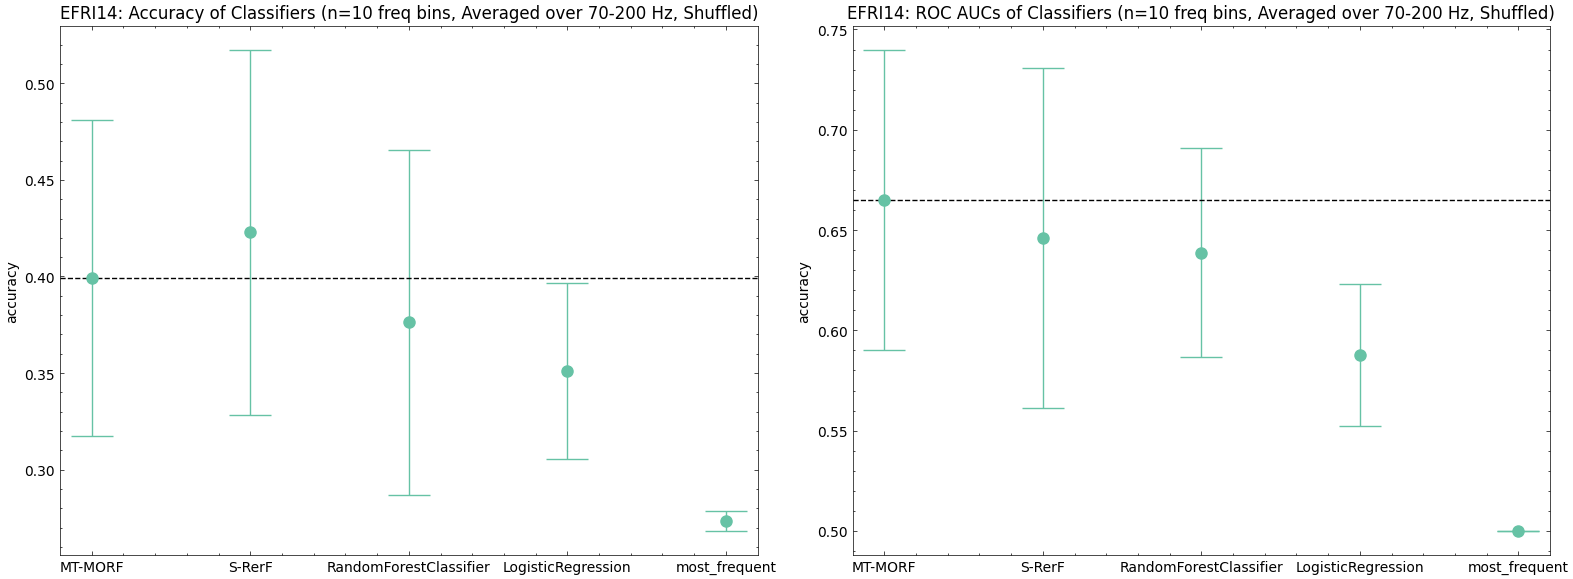

In [17]:
## Fit models
clf_scores = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=True, shuffle_channels=True, avg_freq=True, nfreqs=nfreqs, lfreq=lfreq, hfreq=hfreq, random_state=rng)

## Plot results
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(16, 6))
axs = axs.flatten()
plot_accuracies(clf_scores, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (n={nfreqs} freq bins, Averaged over {lfreq}-{hfreq} Hz, Shuffled)")

plot_roc_aucs(clf_scores, ax=axs[1])
axs[1].set(ylabel="accuracy", title=f"{subject.upper()}: ROC AUCs of Classifiers (n={nfreqs} freq bins, Averaged over {lfreq}-{hfreq} Hz, Shuffled)")

fig.tight_layout();

### Shuffled vs Unshuffled (Freq Domain, No Averaging)

Not setting metadata
100%|██████████| 5/5 [03:16<00:00, 39.27s/it]


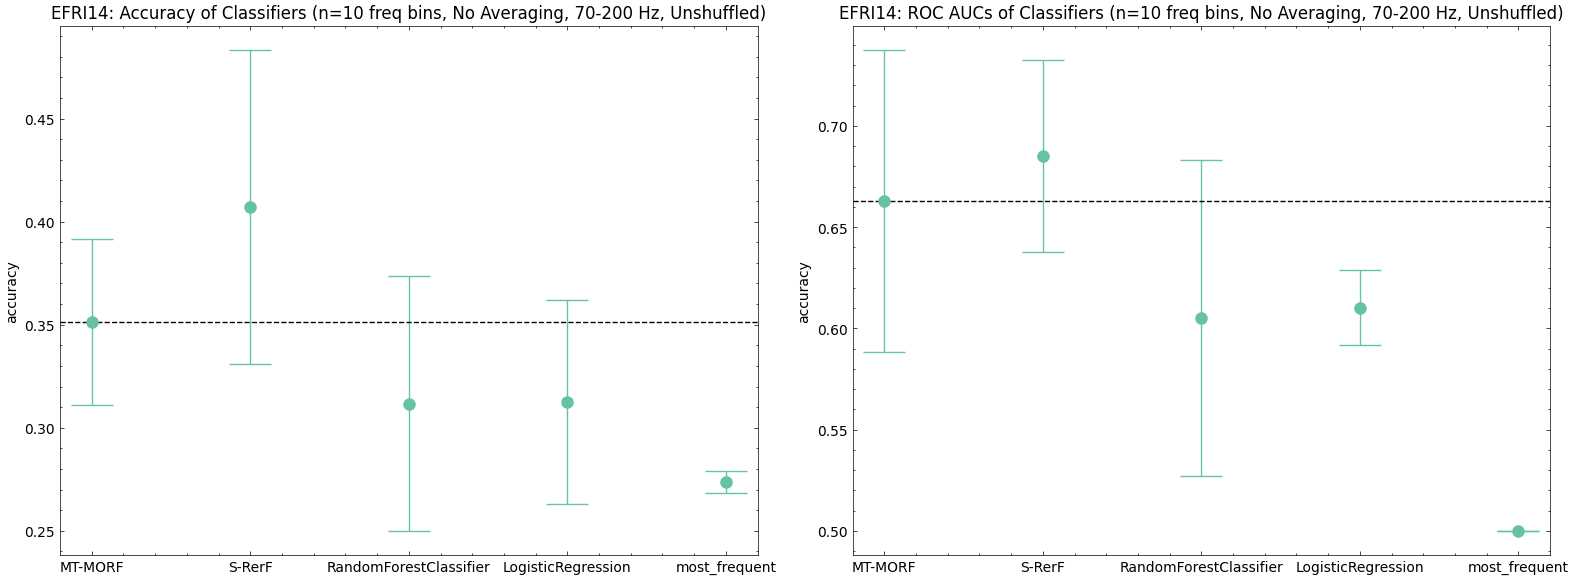

In [18]:
## Fit models
clf_scores = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=True, avg_freq=False, nfreqs=nfreqs, lfreq=lfreq, hfreq=hfreq, random_state=rng)

## Plot results
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(16, 6))
axs = axs.flatten()
plot_accuracies(clf_scores, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (n={nfreqs} freq bins, No Averaging, {lfreq}-{hfreq} Hz, Unshuffled)")

plot_roc_aucs(clf_scores, ax=axs[1])
axs[1].set(ylabel="accuracy", title=f"{subject.upper()}: ROC AUCs of Classifiers (n={nfreqs} freq bins, No Averaging, {lfreq}-{hfreq} Hz, Unshuffled)")

fig.tight_layout();

Not setting metadata
100%|██████████| 5/5 [03:24<00:00, 40.84s/it]


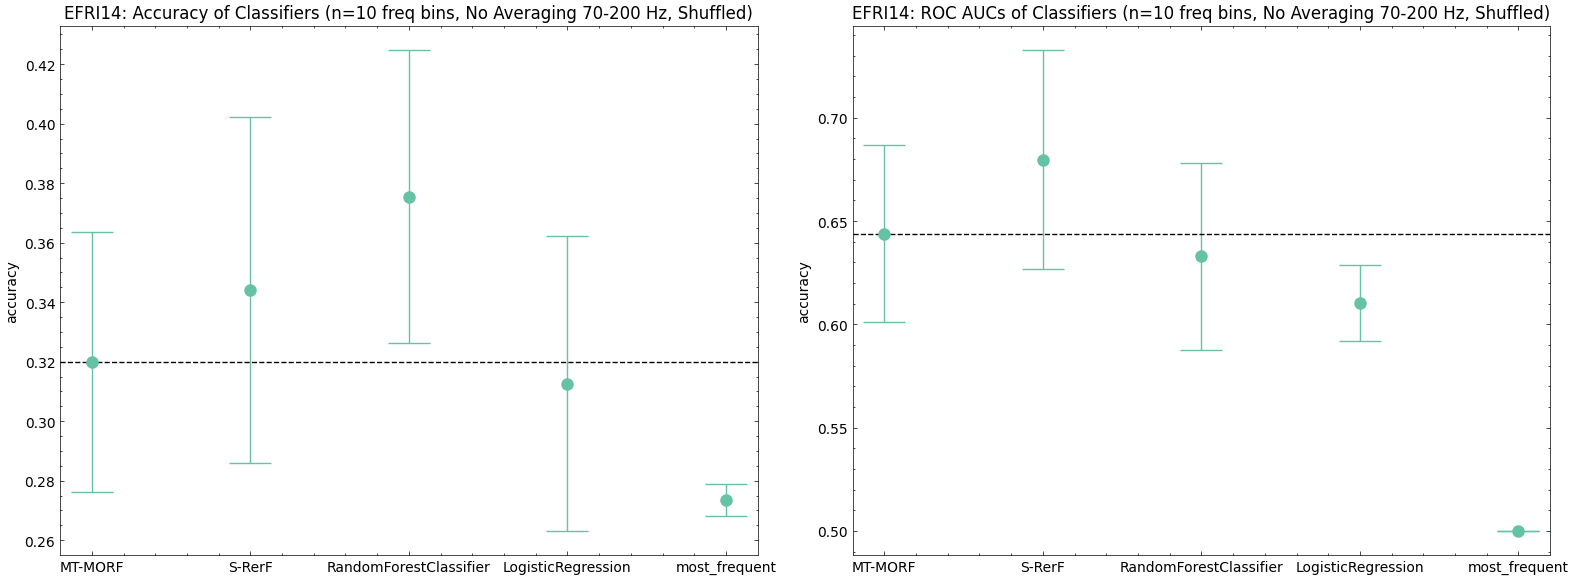

In [19]:
## Fit models
clf_scores = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=True, shuffle_channels=True, avg_freq=False, nfreqs=nfreqs, lfreq=lfreq, hfreq=hfreq, random_state=rng)

## Plot results
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(16, 6))
axs = axs.flatten()
plot_accuracies(clf_scores, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (n={nfreqs} freq bins, No Averaging {lfreq}-{hfreq} Hz, Shuffled)")

plot_roc_aucs(clf_scores, ax=axs[1])
axs[1].set(ylabel="accuracy", title=f"{subject.upper()}: ROC AUCs of Classifiers (n={nfreqs} freq bins, No Averaging {lfreq}-{hfreq} Hz, Shuffled)")

fig.tight_layout();

## EFRI07

In [20]:
# subject identifiers
subject = "efri07"
session = "efri"
task = "move"
acquisition = "seeg"
run = "01"
kind = "ieeg"

bids_path = BIDSPath(subject=subject, session=session, task=task,
                     acquisition=acquisition, run=run, suffix=kind, extension=".vhdr", root=bids_root)

In [21]:
# fetch labels
labels, trial_ids = read_label(bids_path, trial_id=None, label_keyword="target_direction")

# we don't want perturbed trials
behav_tsv, events_tsv = get_trial_info(bids_path)
success_trial_flag = np.array(list(map(int, behav_tsv["successful_trial_flag"])))
success_inds = np.where(success_trial_flag == 1)[0]
force_mag = np.array(behav_tsv['force_magnitude'], np.float64)[success_inds]

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where((np.isnan(labels) | (force_mag > 0)))[0]
labels = np.delete(labels, unsuccessful_trial_inds)

# get preprocessed epochs data
fname = os.path.splitext(bids_path.basename)[0] + "-epo.fif"
fpath = derivatives_path / subject / fname

epochs = mne.read_epochs(fpath, preload=True)
epochs = epochs.drop(unsuccessful_trial_inds)

Out of 98 trials, there were 96 successful trials in /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Out of 98 trials, there were 96 successful trials in /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Reading /workspaces/research/mnt/data/efri/derivatives/preprocessed/tmin=-0.75-tmax=1.25/band-pass=1-1000Hz-downsample=500/efri07/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -750.00 ...    1248.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Dropped 20 epochs: 3, 4, 9, 12, 13, 33, 38, 40, 41, 48, 51, 53, 68, 76, 81, 82, 86, 87, 90, 95


In [22]:
bids_path = BIDSPath(subject=subject, session=session, task=task,
                    acquisition=acquisition, run=run, suffix=kind, extension=".tsv", root=bids_root)
bids_path.update(suffix="channels")
bads = _get_bad_chs(bids_path)

tmp = _from_tsv(bids_path)
tmp = [
    (name, anat) 
    for (name, anat) in zip(tmp["name"], tmp["anat"]) 
    if name not in bads
]

channels = pd.DataFrame(tmp, columns=["name", "anat"])
sorted_channels = channels.sort_values(["anat"])
sorted_channels.head()

name             anat
76  REF2               CZ
75  REF1               FZ
77     E               PZ
53    P8  angular gyrus R
54    P7  angular gyrus R

In [23]:
sorted_channels[sorted_channels["anat"].str.contains("insular cortex|central sulcus|middle temporal gyrus")]

name                          anat
23   U2  insular cortex (posterior) R
24   U1  insular cortex (posterior) R
39   B7       middle temporal gyrus R
38   B8       middle temporal gyrus R
36  B10       middle temporal gyrus R
31   F8       middle temporal gyrus R
30   F9       middle temporal gyrus R
37   B9       middle temporal gyrus R

In [24]:
anat = sorted_channels["anat"].str.contains("insular cortex|central sulcus|middle temporal gyrus")
picks = list(sorted_channels[anat]["name"])
epochs_anat = epochs.pick_channels(picks)

### Shuffled vs Unshuffled (Time Domain)

100%|██████████| 5/5 [00:23<00:00,  4.68s/it]


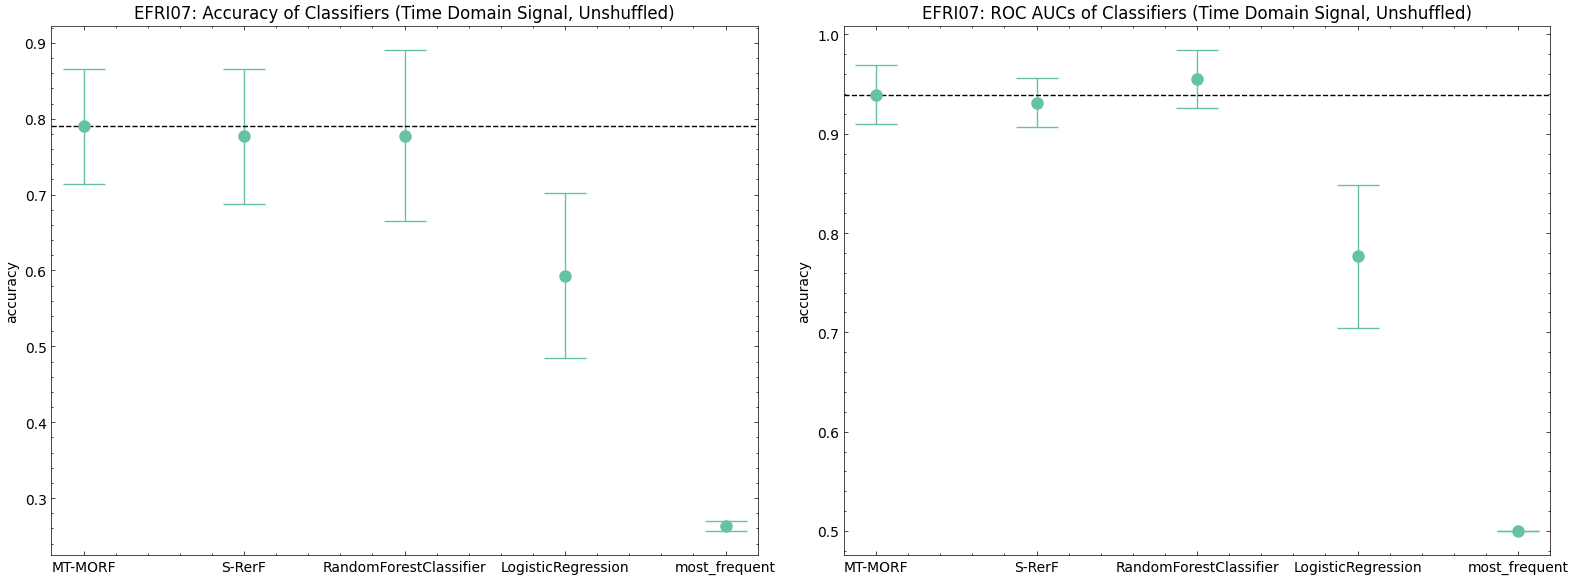

In [25]:
rng = 1
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

## Fit models
clf_scores = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=False, shuffle_channels=False, random_state=rng)

## Plot results
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(16, 6))
axs = axs.flatten()
plot_accuracies(clf_scores, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (Time Domain Signal, Unshuffled)")

plot_roc_aucs(clf_scores, ax=axs[1])
axs[1].set(ylabel="accuracy", title=f"{subject.upper()}: ROC AUCs of Classifiers (Time Domain Signal, Unshuffled)")

fig.tight_layout();

100%|██████████| 5/5 [00:22<00:00,  4.52s/it]


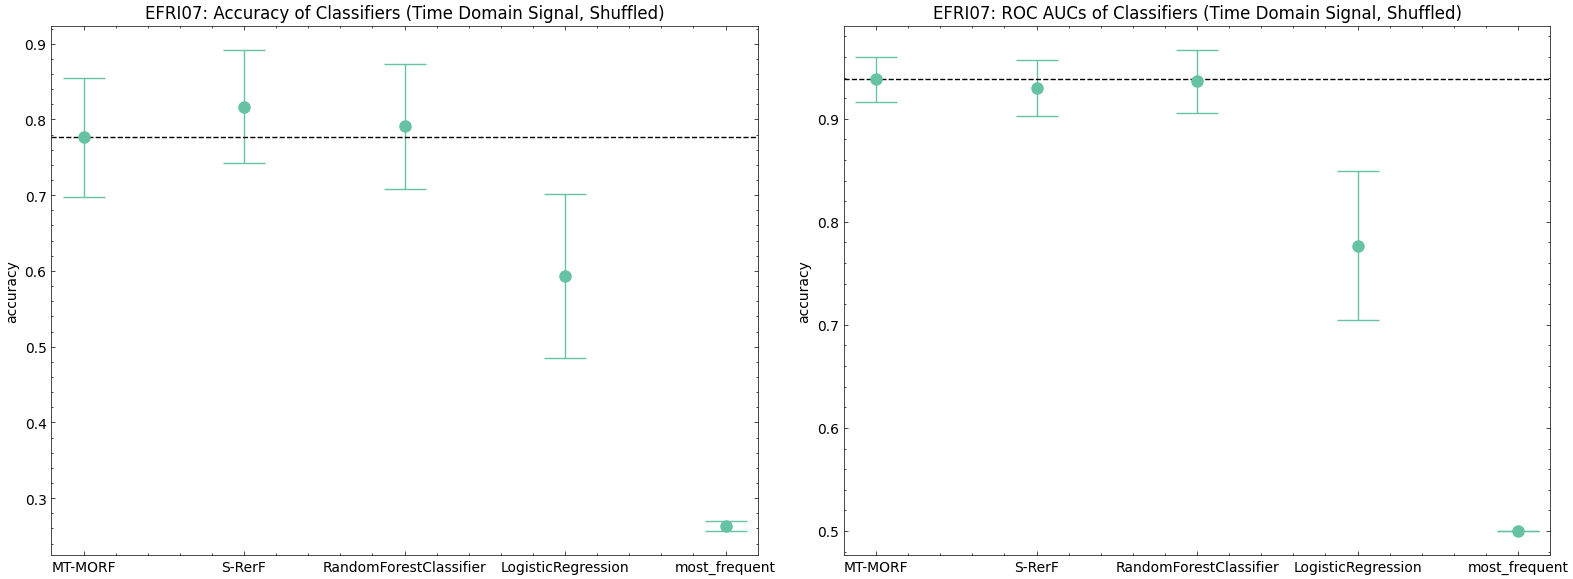

In [26]:
## Fit model
clf_scores = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=False, shuffle_channels=True, random_state=rng)

## Plot results
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(16, 6))
axs = axs.flatten()
plot_accuracies(clf_scores, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (Time Domain Signal, Shuffled)")

plot_roc_aucs(clf_scores, ax=axs[1])
axs[1].set(ylabel="accuracy", title=f"{subject.upper()}: ROC AUCs of Classifiers (Time Domain Signal, Shuffled)")

fig.tight_layout();

### Shuffled vs Unshuffled (Freq Domain, Averaged)

Not setting metadata
100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


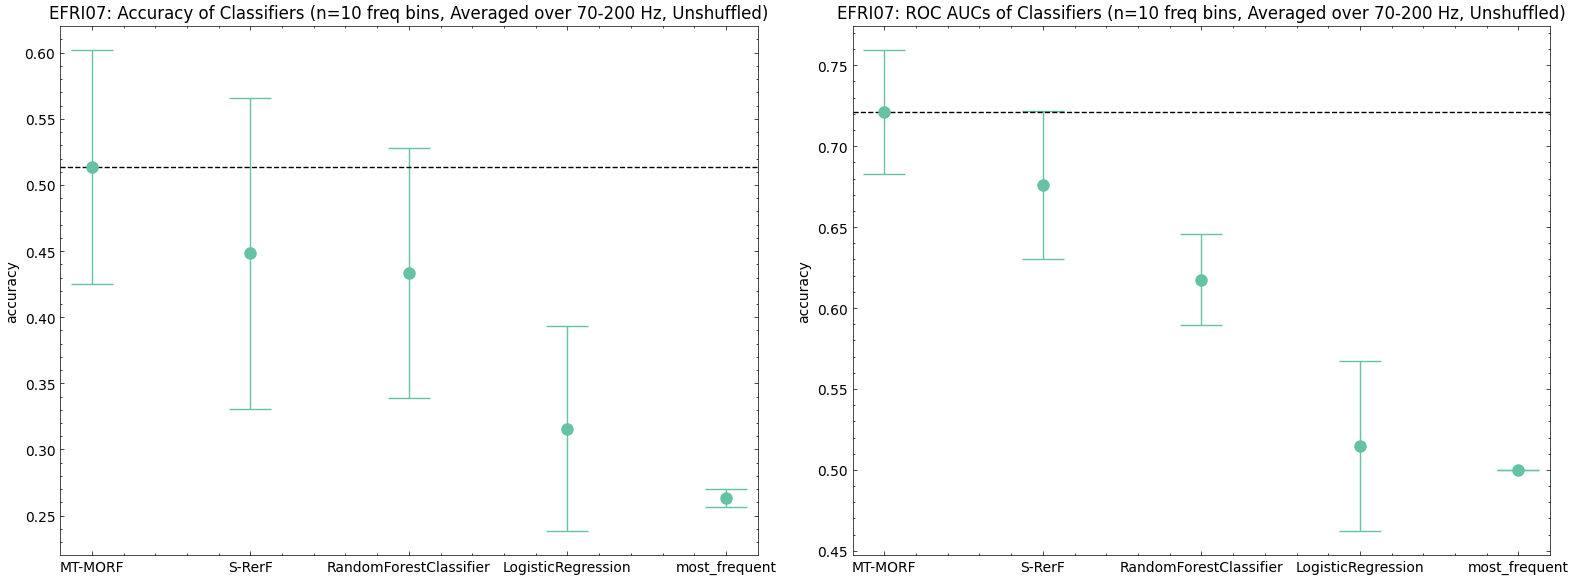

In [27]:
nfreqs = 10
lfreq, hfreq = (70, 200)

## Fit models
clf_scores = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=True, avg_freq=True, nfreqs=nfreqs, lfreq=lfreq, hfreq=hfreq, random_state=rng)

## Plot results
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(16, 6))
axs = axs.flatten()
plot_accuracies(clf_scores, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (n={nfreqs} freq bins, Averaged over {lfreq}-{hfreq} Hz, Unshuffled)")

plot_roc_aucs(clf_scores, ax=axs[1])
axs[1].set(ylabel="accuracy", title=f"{subject.upper()}: ROC AUCs of Classifiers (n={nfreqs} freq bins, Averaged over {lfreq}-{hfreq} Hz, Unshuffled)")

fig.tight_layout();

Not setting metadata
100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


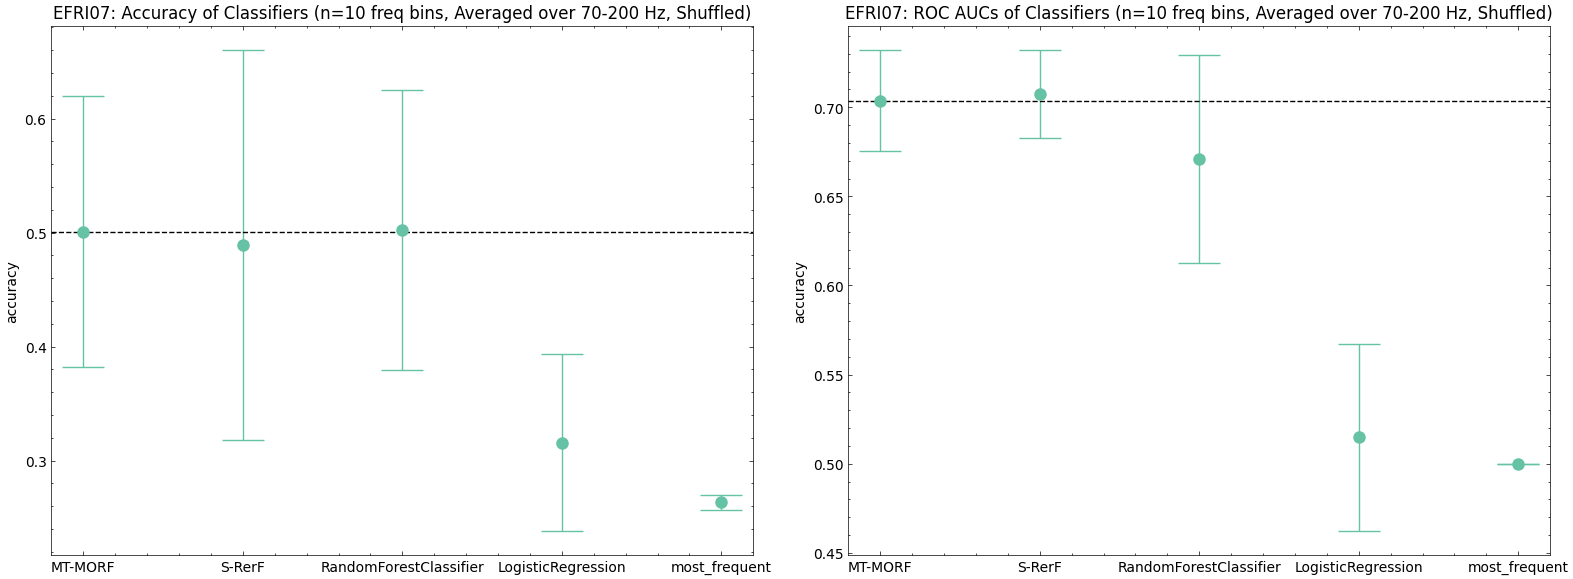

In [28]:
## Fit models
clf_scores = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=True, shuffle_channels=True, avg_freq=True, nfreqs=nfreqs, lfreq=lfreq, hfreq=hfreq, random_state=rng)

## Plot results
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(16, 6))
axs = axs.flatten()
plot_accuracies(clf_scores, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (n={nfreqs} freq bins, Averaged over {lfreq}-{hfreq} Hz, Shuffled)")

plot_roc_aucs(clf_scores, ax=axs[1])
axs[1].set(ylabel="accuracy", title=f"{subject.upper()}: ROC AUCs of Classifiers (n={nfreqs} freq bins, Averaged over {lfreq}-{hfreq} Hz, Shuffled)")

fig.tight_layout();

### Shuffled vs Unshuffled (Freq Domain, No Averaging)

Not setting metadata
100%|██████████| 5/5 [01:06<00:00, 13.26s/it]


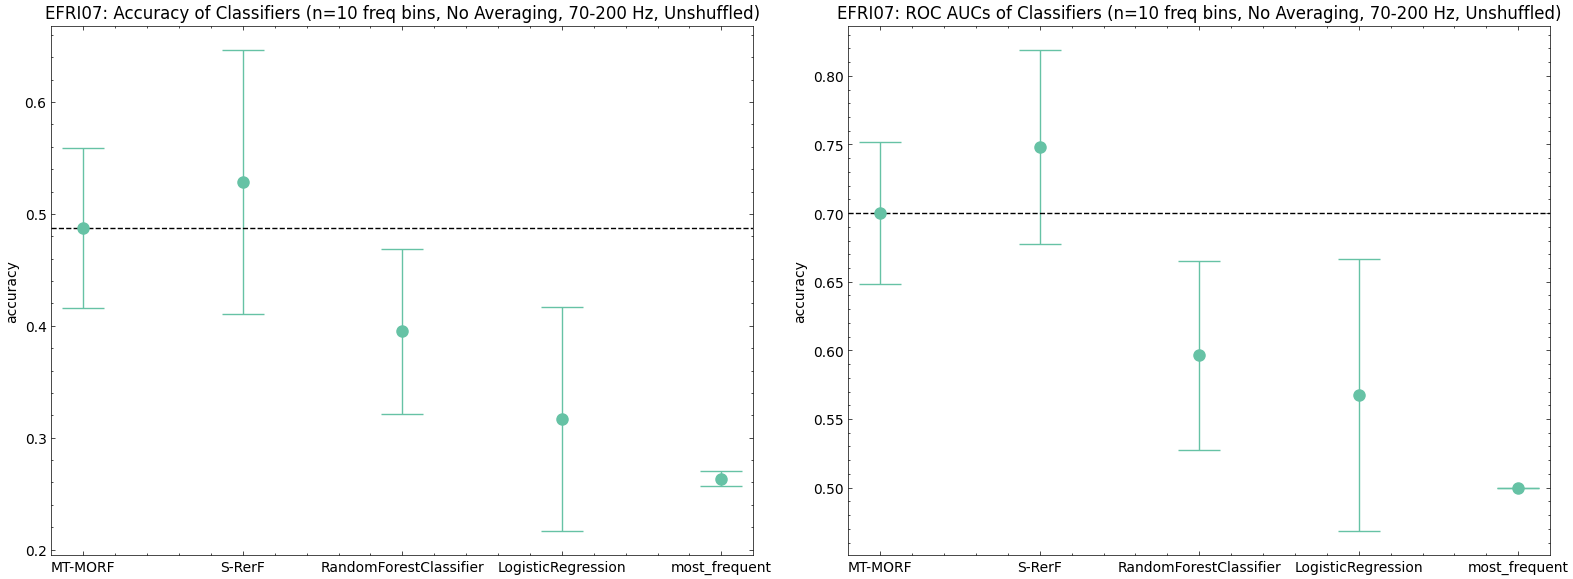

In [29]:
## Fit models
clf_scores = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=True, avg_freq=False, nfreqs=nfreqs, lfreq=lfreq, hfreq=hfreq, random_state=rng)

## Plot results
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(16, 6))
axs = axs.flatten()
plot_accuracies(clf_scores, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (n={nfreqs} freq bins, No Averaging, {lfreq}-{hfreq} Hz, Unshuffled)")

plot_roc_aucs(clf_scores, ax=axs[1])
axs[1].set(ylabel="accuracy", title=f"{subject.upper()}: ROC AUCs of Classifiers (n={nfreqs} freq bins, No Averaging, {lfreq}-{hfreq} Hz, Unshuffled)")

fig.tight_layout();

In [30]:
## Fit models
clf_scores = run_classifier_comparison(reordered_chs, labels, cv, freq_domain=True, shuffle_channels=True, avg_freq=False, nfreqs=nfreqs, lfreq=lfreq, hfreq=hfreq, random_state=rng)

## Plot results
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(16, 6))
axs = axs.flatten()
plot_accuracies(clf_scores, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (n={nfreqs} freq bins, No Averaging {lfreq}-{hfreq} Hz, Shuffled)")

plot_roc_aucs(clf_scores, ax=axs[1])
axs[1].set(ylabel="accuracy", title=f"{subject.upper()}: ROC AUCs of Classifiers (n={nfreqs} freq bins, No Averaging {lfreq}-{hfreq} Hz, Shuffled)")

fig.tight_layout();

Not setting metadata


IndexError: boolean index did not match indexed array along dimension 0; dimension is 128 but corresponding boolean dimension is 76